## Imports

In [1]:
# Unsere Klassen
import load_data
import preprocess
import testing_models # Use: build_model9v3(img_width, img_height, char) 
#Imports
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import time
import os

## Constants 

In [2]:
# SAVE_HISTORY = True: Es speichert die Plots im Ordner "test_results"
SAVE_HISTORY = True

# MODEL_SAVE = True: Es speichert das Modell im Ordner "arch" mit den Name von "MODEL_NAME"
MODEL_SAVE = False
MODEL_NAME = "alexejV1" # Der Name wird am Ende im Plot mit angezeigt 
MODEL_DIR_NAME = pathlib.Path(os.getcwd()).joinpath('arch')
TEST_RESULT_DIR_NAME = pathlib.Path(os.getcwd()).joinpath('test_results')

#Anzahl an Epochen die maximal durchlaufen werden
EPOCHS = 100

# IMAGE_WIDTH   : Default 512
# IMAGE_HEIGHT  : Default 32
IMAGE_WIDTH = preprocess.image_width
IMAGE_HEIGHT = preprocess.image_height

## Load Data

In [3]:
load_data.print_samples()
x_train_img_paths, y_train_labels = load_data.get_train_data()
x_test_img_paths, y_test_labels = load_data.get_test_data()
x_val_img_paths, y_val_labels = load_data.get_validation_data()

Total train samples: 10209
Total validation samples: 567
Total test samples: 568
Maximum length:  93
Vocab size:  79


In [4]:
print(f"Training path: {x_train_img_paths[0:2]}", y_train_labels[0:2])
print(f"Validation path: {x_val_img_paths[0:2]}", y_val_labels[0:2])
print(f"Testing path: {x_test_img_paths[0:2]}", y_test_labels[0:2])

Training path: ['data\\lines\\m06\\m06-106\\m06-106-03.png', 'data\\lines\\a01\\a01-132u\\a01-132u-03.png'] ['and|Haris|there|were|many|events|.|Chief|of|these|was', 'adjust|the|financing|-|which|Mr.|Powell']
Validation path: ['data\\lines\\b04\\b04-034\\b04-034-04.png', 'data\\lines\\a05\\a05-004\\a05-004-05.png'] ['Newmarket|urban|council|,|says|:|"|I|shall|always|feel|this|as|a', 'and|operations|.|This|would|apply|also|in|the']
Testing path: ['data\\lines\\a02\\a02-093\\a02-093-01.png', 'data\\lines\\n02\\n02-049\\n02-049-03.png'] ['priority|to|the|clash|over|Northern|Rhodesia|on|his', 'look|as|though|it|was|only|what|you|expected|of|me|,']


## Create Dataset

In [5]:
# Has to be here because load data functions need to be called before
import tokenizer

# takes eternity
#x_train, y_train = tokenizer.prepare_data(x_train_img_paths, y_train_labels) 
#x_test, y_test = tokenizer.prepare_data(x_test_img_paths, y_test_labels)
train_ds = tokenizer.prepare_dataset(x_train_img_paths, y_train_labels)
val_ds = tokenizer.prepare_dataset(x_val_img_paths, y_val_labels)
test_ds = tokenizer.prepare_dataset(x_test_img_paths, y_test_labels)

## Show Examples

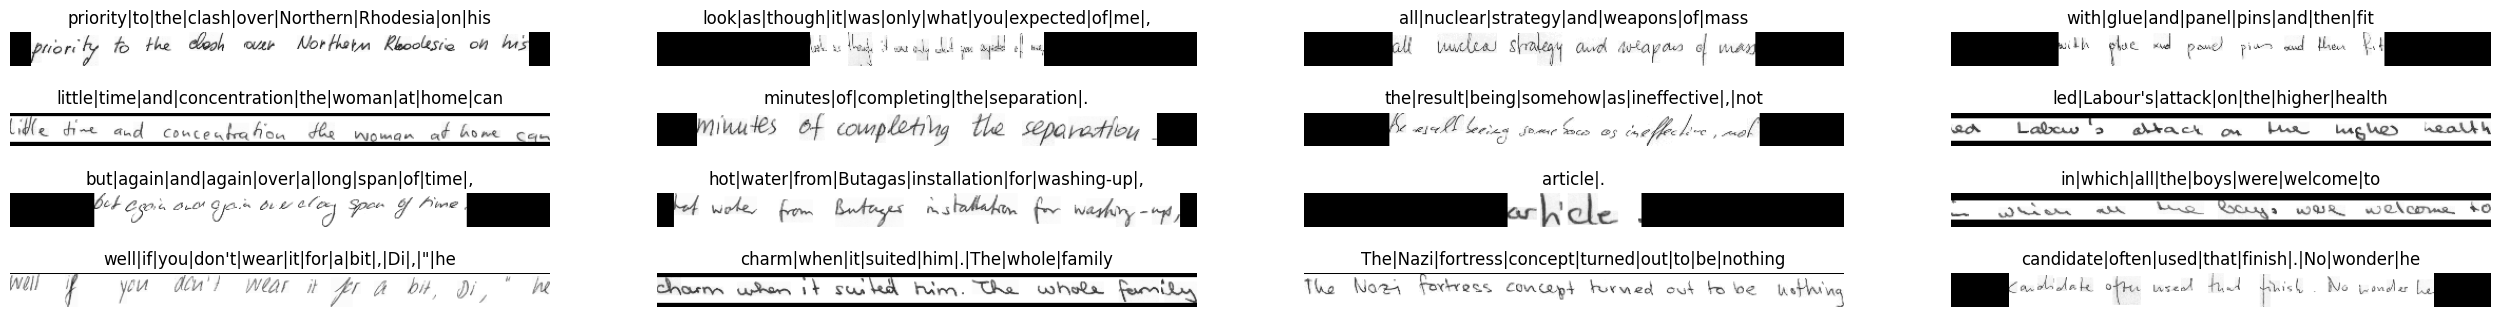

In [6]:
for data in test_ds.take(1):
    images, labels = data["image"], data["label"]

    ax = plt.subplots(4, 4, figsize=(32, 4))[1]

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, tokenizer.padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(tokenizer.num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")

plt.show()

# Data Augmentation

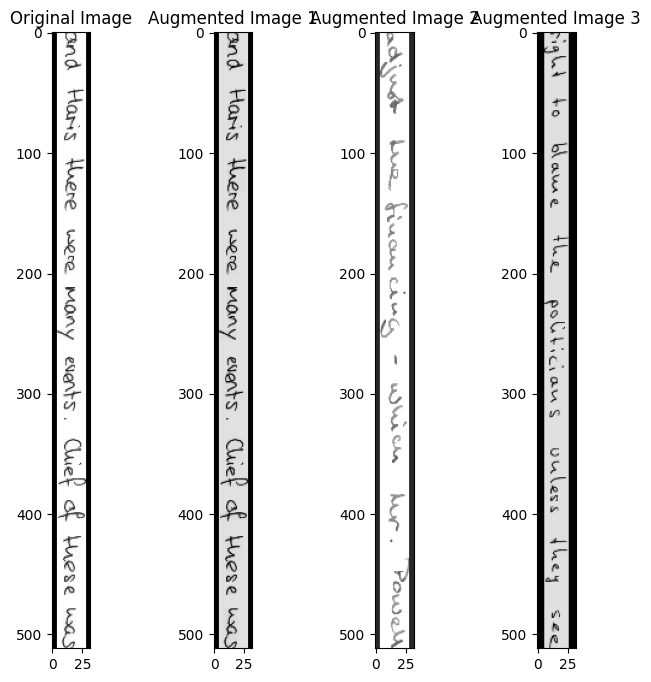

In [7]:
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.RandomBrightness(0.5,value_range=(0, 1), seed=42)
    ]
)

for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

# Display the original image
plt.figure(figsize=(8, 8))
plt.subplot(1, 4, 1)
plt.imshow(images[0].numpy(), cmap='gray', vmin=0, vmax=1)
plt.title("Original Image")

# Apply data augmentation to the image
augmented_images = data_augmentation(images, training=True)

# Display the augmented images
for i in range(3):
    plt.subplot(1, 4, i + 2)
    plt.imshow(augmented_images[i].numpy(), cmap='gray', vmin=0, vmax=1)
    plt.title(f"Augmented Image {i+1}")
    
plt.show()

## Train Keras Model

In [8]:
def train_model(model):
    prediction_model = keras.models.Model(model.get_layer(name="image").input, model.get_layer(name="dense2").output)

    checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True)
    early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[checkpoint, early_stopping])    
    return prediction_model, history

In [9]:
# Default
# model = testing_models.build_model_default(IMAGE_WIDTH, IMAGE_HEIGHT, char, MODEL_NAME)

char = len(tokenizer.char_to_num.get_vocabulary())
model = testing_models.build_model9v3(IMAGE_WIDTH, IMAGE_HEIGHT, char)
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 512, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 512, 32, 48)  480         ['image[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 512, 32, 96)  41568       ['Conv1[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 256, 16, 96)  0           ['Conv2[0][0

In [10]:
start_time = time.time()

prediction_model, history = train_model(model)

total_duration = time.time() - start_time
print("Gesamte Trainingsdauer: {time}s".format(time=round(total_duration)))

Epoch 1/100
160/160 [==============================] - 38s 189ms/step - loss: 139.9127 - val_loss: 133.8772
Epoch 2/100
160/160 [==============================] - 27s 169ms/step - loss: 134.1832 - val_loss: 133.4545
Epoch 3/100
160/160 [==============================] - 27s 170ms/step - loss: 124.9411 - val_loss: 102.8109
Epoch 4/100
160/160 [==============================] - 26s 165ms/step - loss: 89.4491 - val_loss: 67.8352
Epoch 5/100
160/160 [==============================] - 27s 170ms/step - loss: 61.1269 - val_loss: 43.3091
Epoch 6/100
160/160 [==============================] - 27s 170ms/step - loss: 43.9618 - val_loss: 33.0234
Epoch 7/100
160/160 [==============================] - 26s 165ms/step - loss: 35.7424 - val_loss: 27.6128
Epoch 8/100
160/160 [==============================] - 27s 167ms/step - loss: 30.7668 - val_loss: 23.6256
Epoch 9/100
160/160 [==============================] - 27s 168ms/step - loss: 27.4723 - val_loss: 21.9201
Epoch 10/100
160/160 [==================

## Plot helper functions


In [11]:
def plot_history(history, name, dir_path, save_fig):
    """
    Plottet die Historie des Trainings eines Models und speichert die in einem Verzeichnis ab 

    :param history: Das trainierte Modell
    :param name: Name, wie das Modell gespeicht werden soll
    :param name: Verzeichniss, wo der Plot gespeichert weren soll
    :return: void
    """
    metrics = history.history
    plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
    plt.legend(['loss', 'val_loss'])
    
    if save_fig:
        plt.title('Name: '+name)
        path = os.path.join(dir_path, name + '_history.png')
        plt.savefig(path)
        
    plt.show()

In [12]:
def create_dir(path_to_dir):
    isExist = os.path.exists(path_to_dir)
    if not isExist:
        os.makedirs(path_to_dir)

In [13]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :load_data.max_len]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(tokenizer.num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [14]:
def plot_evaluation(name, dir_path, save_fig):
    for batch in val_ds.take(1):
        batch_images = batch["image"]
        _, ax = plt.subplots(4, 4, figsize=(32, 4))

        preds = prediction_model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)

        for i in range(16):
            img = batch_images[i]
            img = tf.image.flip_left_right(img)
            img = tf.transpose(img, perm=[1, 0, 2])
            img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
            img = img[:, :, 0]

            title = f"Prediction: {pred_texts[i]}"
            ax[i // 4, i % 4].imshow(img, cmap="gray")
            ax[i // 4, i % 4].set_title(title)
            ax[i // 4, i % 4].axis("off")   
    if save_fig:
        path = os.path.join(dir_path, name + '_result.png')
        plt.savefig(path)
        
    plt.show()

## Model Testing

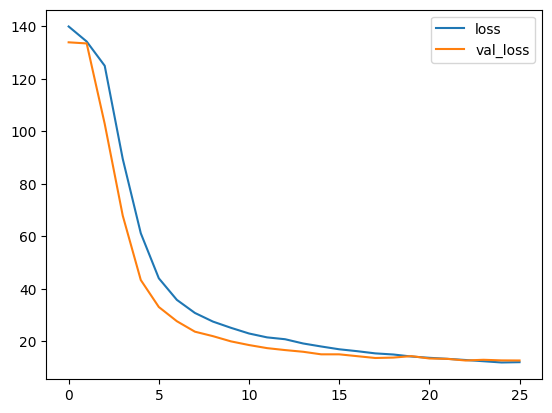

2/2 [==============================] - 2s 24ms/step


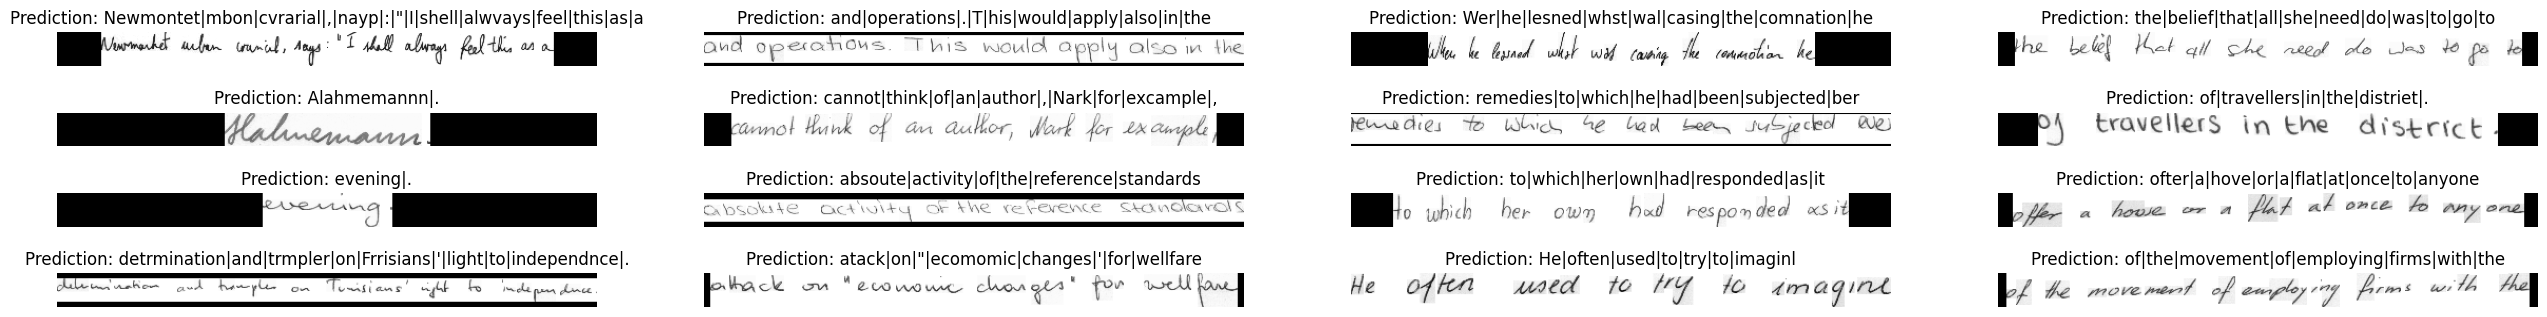

In [15]:
files_with_model_name = [file for file in os.listdir(TEST_RESULT_DIR_NAME) if MODEL_NAME in file]
metrics = history.history

NAME = "{name}_{epoch}E_{height}H_{width}W_{loss}L_{val_loss}VL_{time}s".format(
    name=MODEL_NAME, epoch=history.epoch[-1], height=IMAGE_HEIGHT, width=IMAGE_WIDTH,
    loss=round(metrics['loss'][-1],2), val_loss=round(metrics['val_loss'][-1], 2), time=round(total_duration))

if not files_with_model_name:
    if SAVE_HISTORY:
        if not os.path.exists(TEST_RESULT_DIR_NAME):
            create_dir(TEST_RESULT_DIR_NAME)
        plot_history(history, NAME, TEST_RESULT_DIR_NAME, True)
        plot_evaluation(NAME, TEST_RESULT_DIR_NAME, True)
else:
    plot_history(history, name=None, dir_path=None, save_fig=False)
    plot_evaluation(name=None, dir_path=None, save_fig=False)

# Save the Model

In [16]:
if MODEL_SAVE:
    if not os.path.exists(MODEL_DIR_NAME):
        create_dir(MODEL_DIR_NAME)
    model.save(os.path.join(MODEL_DIR_NAME, "{model_name}".format(model_name=MODEL_NAME)))
    model.save_weights(os.path.join(MODEL_DIR_NAME, "weights.keras"), overwrite=True, save_format=None, options=None)
    json_string = model.to_json()

    with open(os.path.join(MODEL_DIR_NAME, "model"),'w') as f:
        f.write(json_string)